# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [232]:
import sys
import pickle
import spektral
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from spektral import models
from spektral.models.gnn_explainer import GNNExplainer
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Dropout,
    Dense,
    AveragePooling1D,
    Concatenate,
    Conv1D,
    Flatten,
)
from tensorflow.keras.models import Model

sys.executable

# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [233]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


In [234]:
def calculate_d_band(energy, total_density):
    # total_density = np.sum(densities, axis=1)
    area = np.trapz(total_density, energy)
    # print(area)
    center = np.trapz(energy * total_density, energy) / area
    
    m = []
    m.append(center)
    for i in range(4):
        j = i+2
        # j阶中心矩
        moment = np.trapz((energy - center)**j * total_density, energy) / area
        m.append(moment)
    return m

# Load Data

In [235]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [236]:
# 从文件中提取数据
file_path = "../shear2/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset3 = pickle.load(file)

print(dataset3)  # 输出：[1, 2, 3, 4, 5]
dataset3[0].x.shape

MyGraphDataset(n_graphs=60)


(8, 4000)

In [237]:
# 从文件中提取数据
file_path = "../shear/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=120)


(8, 4000)

In [238]:
# 从文件中提取数据
data_path = "./vasp_cal/"  # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + "dos_energy_data.pkl"
with open(dos_energy_data_file, "rb") as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=594)


(8, 4000)

In [239]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)

for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)

for i in range(len(dataset3)):
    g = dataset3[i]
    graph_data.append(g)

dataset = MyGraphDataset(graph_data)
dataset

MyGraphDataset(n_graphs=774)

In [240]:
dband = np.sum(graph_data[0].x[0].reshape(-1,5), axis=1)
erange = np.linspace(-7, 1, num=dband.shape[0])
dband.shape

(800,)

In [241]:
erange.shape

(800,)

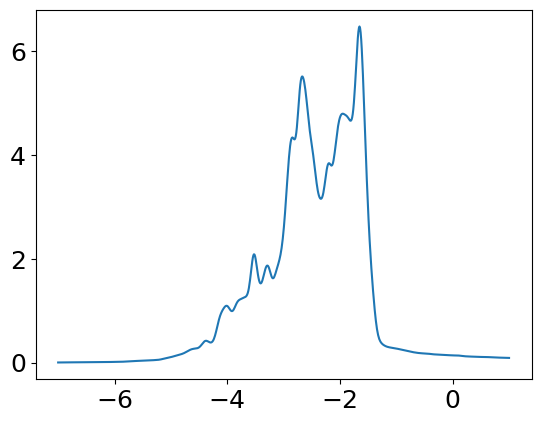

In [242]:
plt.plot(erange, dband)

In [243]:
import copy
graph_data3 = copy.deepcopy(graph_data)
erange = np.linspace(-7, 1, num=dband.shape[0])
for i in range(len(graph_data3)):
    dband = np.sum(graph_data3[i].x[0].reshape(-1,5), axis=1)
    nx = np.zeros((8,2))
    m = np.array(calculate_d_band(erange, dband))
    nx[:6,:] =  m[:2]
    print(m[:2])
    graph_data3[i].x = nx
dataset2 = MyGraphDataset(graph_data3)

[-2.43411314  0.78297321]
[-2.44324605  0.79920977]
[-2.46599096  0.82119357]
[-2.49128234  0.84663502]
[-2.44816344  0.79930666]
[-2.43985819  0.79990894]
[-2.4438607   0.80336977]
[-2.51777831  0.88205668]
[-2.40964072  0.76762581]
[-2.486026    0.85043246]
[-2.47181275  0.82850257]
[-2.42412576  0.77357502]
[-2.42172026  0.78156347]
[-2.50903672  0.87029832]
[-2.43911265  0.79718037]
[-2.45178643  0.81020064]
[-2.4563709   0.81477501]
[-2.5140941   0.87292069]
[-2.48006145  0.84026473]
[-2.45764133  0.81485494]
[-2.45226225  0.80204074]
[-2.42686518  0.78815445]
[-2.46215888  0.82093937]
[-2.42637746  0.77231883]
[-2.51537439  0.87103967]
[-2.4651425   0.82463231]
[-2.42361754  0.77933457]
[-2.50071104  0.86052666]
[-2.50156988  0.85739025]
[-2.44605373  0.80886259]
[-2.40701779  0.74583618]
[-2.48215076  0.83925377]
[-2.44492066  0.8043958 ]
[-2.44706091  0.79956614]
[-2.4936656   0.85390476]
[-2.4417716   0.79986897]
[-2.43357342  0.78798831]
[-2.42360729  0.78439624]
[-2.4723264 

In [244]:
nx

array([[-2.52690799,  0.9029882 ],
       [-2.52690799,  0.9029882 ],
       [-2.52690799,  0.9029882 ],
       [-2.52690799,  0.9029882 ],
       [-2.52690799,  0.9029882 ],
       [-2.52690799,  0.9029882 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

# New GCN model

In [245]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(4000, 4, 1)

In [246]:
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of training epochs
batch_size = 16  # Batch size

In [247]:
channels = 5
length = int(F / channels)  # 400

In [248]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = ECCConv(128, activation="relu")
        self.conv2 = ECCConv(64, activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output

In [249]:
model = Net()
model.layers

In [250]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data3)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [251]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [252]:
istrain = True
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights("./vasp_cal/model_weightas")  # 保存GCN權重
else:
    model.load_weights("./vasp_cal/model_weightas")  # 加载GCN权重

Loss: 1.5914877653121948
Loss: 0.13135157525539398
Loss: 0.11389126628637314
Loss: 0.10498327761888504
Loss: 0.09494448453187943
Loss: 0.0746980756521225
Loss: 0.06561882048845291
Loss: 0.06066786125302315
Loss: 0.05841997638344765
Loss: 0.058618977665901184
Loss: 0.05775589868426323
Loss: 0.05651991069316864
Loss: 0.05361945927143097
Loss: 0.06093236431479454
Loss: 0.060540784150362015
Loss: 0.05124852806329727
Loss: 0.04829230159521103
Loss: 0.050098661333322525
Loss: 0.05237060785293579
Loss: 0.04771607741713524
Loss: 0.041307177394628525
Loss: 0.03553566709160805
Loss: 0.03590187057852745
Loss: 0.037554770708084106
Loss: 0.03926295414566994
Loss: 0.03514471650123596
Loss: 0.03569882735610008
Loss: 0.03712736442685127
Loss: 0.03513367474079132
Loss: 0.02756751887500286
Loss: 0.02762584201991558
Loss: 0.027402551844716072
Loss: 0.02856478840112686
Loss: 0.02744237333536148
Loss: 0.02729605883359909
Loss: 0.02678263932466507
Loss: 0.027218854054808617
Loss: 0.02782190404832363
Loss: 0

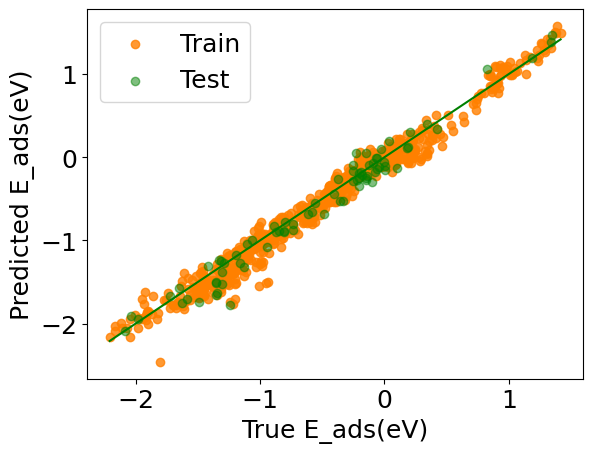

In [253]:
# Train/valid/test split
data = np.array(graph_data3)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

# New GCN

In [515]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(1, 4, 1)

In [516]:
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of training epochs
batch_size = 16  # Batch size

In [517]:
channels = 5
length = int(F / channels)  # 400

In [518]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = ECCConv(32, activation="relu")
        self.conv2 = ECCConv(32, activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output

In [519]:
model = Net()
model.layers

In [520]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data3)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [521]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [522]:
istrain = True
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights("./vasp_cal/model_weightas")  # 保存GCN權重
else:
    model.load_weights("./vasp_cal/model_weightas")  # 加载GCN权重

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Loss: 93.01438903808594
Loss: 0.4180999994277954
Loss: 0.1636209785938263
Loss: 0.13537150621414185
Loss: 0.1300019919872284
Loss: 0.13870029151439667
Loss: 0.15183541178703308
Loss: 0.12973257899284363
Loss: 0.13299213349819183
Loss: 0.1338285505771637
Loss: 0.1897159218788147
Loss: 0.24483038485050201
Loss: 0.20520907640457153
Loss: 0.12630411982536316
Loss: 0.09426727890968323
Loss: 0.08735781162977219
Loss: 0.08352680504322052
Loss: 0.0837189108133316
Loss: 0.13033871352672577
Loss: 0.17251239717006683
Loss: 0.21618346869945526
Loss: 0.26218512654304504
Loss: 0.2842583656311035
Loss: 0.2629260718822479
Loss: 0.21280451118946075
Loss: 0.15960584580898285
Loss: 0.1561705470085144
Loss: 0.16584351658821106
Loss: 0.17598186433315277
Loss: 0.18096868693828583
Loss: 0.17587119340896606
Loss: 0.17866386473178864
Loss: 0.18667559325695038
Loss: 0.15900768339633942
Loss: 0.12542958557605743
Loss: 0.1194043904542923
Loss: 0.119432732462883
Loss: 0.12196329236030579
Loss: 0.12375154346227646


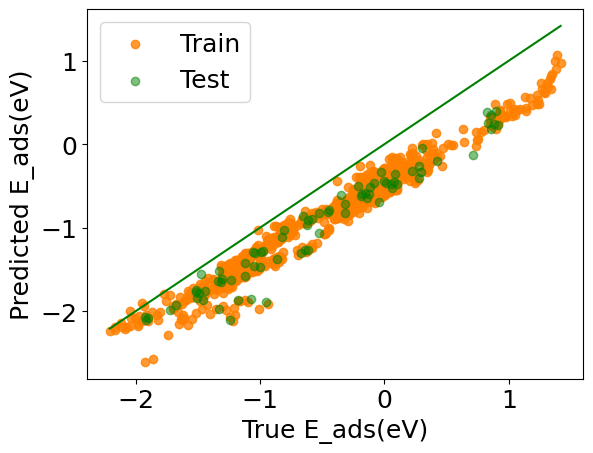

In [523]:
# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

# Build GCN model

In [524]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(1, 4, 1)

In [525]:
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of training epochs
batch_size = 16  # Batch size

In [526]:
def dos_featurizer(length, channel):
    input_dos = Input(shape=(length, channel))  # 400, 5
    x1 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)  # 窗口 步长
    x2 = AveragePooling1D(pool_size=64, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=128, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])  # 沿着最后一个轴拼接
    x = Conv1D(256, 64, activation="relu", padding="same", strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 32, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(64, 16, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(32, 8, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(16, 8, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

In [527]:
def dos_featurizer2(length, channel):
    input_dos = Input(shape=(length, channel))  # 800, 5
    x1 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)
    x2 = AveragePooling1D(pool_size=25, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=200, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])
    x = Conv1D(50, 20, activation="relu", padding="same", strides=4)(x)
    x = BatchNormalization()(x)
    x = Conv1D(75, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(100, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(125, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(150, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

In [528]:
channels = 5
length = int(F / channels)  # 400
shared_conv = dos_featurizer(length, channels)

In [529]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)  # dos feature

        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [530]:
model = Net()
model.layers

In [531]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [532]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [533]:
istrain = False
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights("./vasp_cal/model_weightas")  # 保存GCN權重
else:
    model.load_weights("./vasp_cal/model_weightas")  # 加载GCN权重

In [534]:
# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [535]:
type(data_tr)

numpy.ndarray

In [536]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)

InvalidArgumentError: Exception encountered when calling layer 'net_5' (type Net).

{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 32000 values, but the requested shape has 0 [Op:Reshape]

Call arguments received by layer 'net_5' (type Net):
  • inputs=('tf.Tensor(shape=(8, 4000), dtype=float32)', 'SparseTensor(indices=tf.Tensor(\n[[0 1]\n [0 2]\n [1 0]\n [1 2]\n [1 3]\n [1 4]\n [2 0]\n [2 1]\n [2 4]\n [2 5]\n [2 6]\n [3 1]\n [3 4]\n [4 1]\n [4 2]\n [4 3]\n [4 5]\n [5 2]\n [5 4]\n [6 2]\n [6 7]\n [7 6]], shape=(22, 2), dtype=int64), values=tf.Tensor([1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(22,), dtype=float32), dense_shape=tf.Tensor([8 8], shape=(2,), dtype=int64))', 'tf.Tensor(shape=(22, 4), dtype=float32)', 'tf.Tensor(shape=(8,), dtype=int64)')

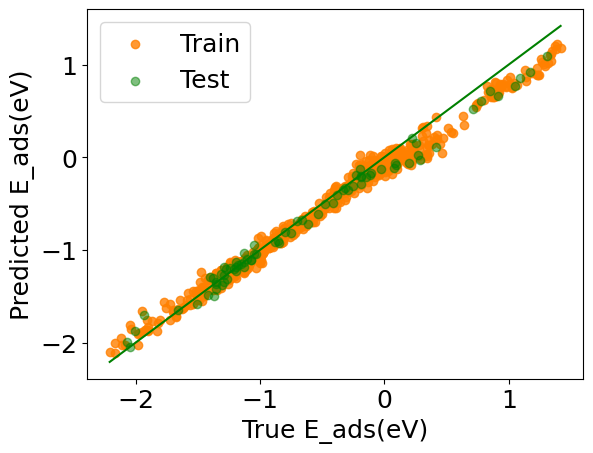

In [ ]:
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

In [ ]:
class FeatureExtraction(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(128, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)

        x = self.conv1([x, a, e])
        feature1 = x  # 保存第一层卷积的特征
        x = self.conv2([x, a, e])
        feature2 = x  # 保存第二层卷积的特征
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        feature3 = output
        output = self.dense(output)

        return output, feature1, feature2, feature3  # 返回输出和需要提取的特征\


Model_feature = FeatureExtraction()

In [ ]:
def plot_feature(X_embedded, z):
    dim = X_embedded.shape[1]
    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("rainbow")

    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("viridis")

    # 设置合适的数值范围
    vmin = np.min(z)
    vmax = np.max(z)
    fig = plt.figure()

    if dim == 1:
        ax = fig.add_subplot()
        ax.scatter(X_embedded[:, 0], z, c=z, cmap=cmap)
        ax.set_xticks([])  # 移除y轴刻度
    elif dim == 2:
        ax = fig.add_subplot()
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
        ax.set_xticks([])  # 移除x轴刻度
        ax.set_yticks([])  # 移除y轴刻度
    elif dim == 3:
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(
            X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=targets, cmap=cmap
        )
        ax.set_xticks([])  # 移除x轴刻度
        ax.set_yticks([])  # 移除y轴刻度
        ax.set_zticks([])  # 移除z轴刻度

    # ax.set_axis_off()  # 移除所有坐标轴刻度
    plt.xticks(fontsize=20) #x轴刻度字体大小
    plt.yticks(fontsize=20) #y轴刻度字体大小
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # 设置一个空数组，传递给 colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Adsorption Energy (eV)")

    # 设置图框线粗细
    bwith = 1.5  # 边框宽度设置为2
    TK = plt.gca()  # 获取边框
    TK.spines["bottom"].set_linewidth(bwith)
    TK.spines["left"].set_linewidth(bwith)
    TK.spines["top"].set_linewidth(bwith)
    TK.spines["right"].set_linewidth(bwith)

    plt.show()

In [ ]:
# Data loaders
loader_data = DisjointLoader(MyGraphDataset(data), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

In [ ]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
fone.shape

(774, 1024)

In [ ]:
X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(fone)

In [ ]:
ftwo = [f.numpy().reshape((1, -1))[0] for f in feature2]
ftwo = np.array(ftwo)
ftwo.shape

fthree = [f.numpy().reshape((1, -1))[0] for f in feature3]
fthree = np.array(fthree)
fthree.shape

(774, 64)

In [ ]:
X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(ftwo)

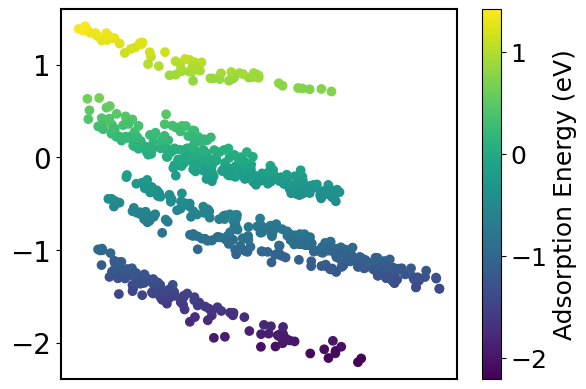

In [ ]:
pca3 = PCA(n_components=1)
X_embedded = pca3.fit_transform(fone)
plot_feature(X_embedded, targets)

In [ ]:
def calculate_d_band_center(energy, densities):
    # 求和所有态密度
    total_density = np.sum(densities, axis=1)
    # 计算能带的面积
    area = np.trapz(total_density, energy)

    # 计算带心
    center = np.trapz(energy * total_density, energy) / area

    return center

In [ ]:
def calculate_d_band_center(energy, densities):
    # 求和所有态密度
    total_density = np.sum(densities, axis=1)
    # 计算能带的面积
    area = np.trapz(total_density, energy)

    # 计算带心
    center = np.trapz(energy * total_density, energy) / area

    return center

In [ ]:
jjj = 300
datatest = data[jjj].x[0].reshape((-1, 5))
print(data[jjj].y)
datatest.shape

-0.7379878000000293


(800, 5)

In [ ]:
calculate_d_band_center(-7 + 0.01 * np.array(range(datatest.shape[0])), datatest)

-2.450501207602817

In [ ]:
data[jjj].x[0].shape

(4000,)

In [ ]:
datatest

array([[0.00036522, 0.00097945, 0.00021249, 0.00098348, 0.00037215],
       [0.00037099, 0.00099006, 0.00021943, 0.00099408, 0.00037796],
       [0.00037687, 0.00100091, 0.00023056, 0.00100483, 0.00038385],
       ...,
       [0.02232202, 0.0164198 , 0.0135064 , 0.01661624, 0.02247795],
       [0.02206211, 0.01635605, 0.01331674, 0.01654562, 0.02220212],
       [0.02181979, 0.01629501, 0.01313678, 0.01647588, 0.021933  ]])

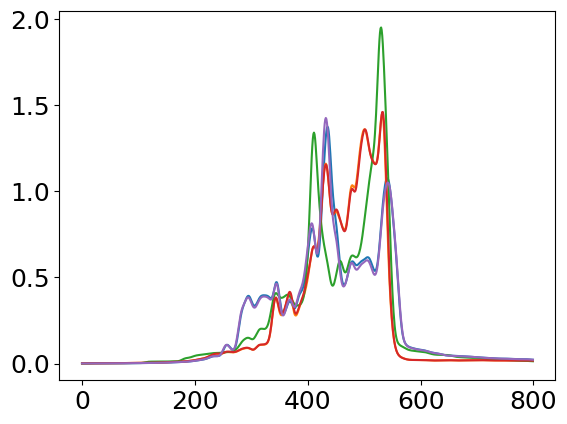

In [ ]:
for i in range(datatest.shape[1]):
    plt.plot(range(datatest.shape[0]), datatest[:, i])
plt.show()

In [ ]:
datatest

array([[0.00036522, 0.00097945, 0.00021249, 0.00098348, 0.00037215],
       [0.00037099, 0.00099006, 0.00021943, 0.00099408, 0.00037796],
       [0.00037687, 0.00100091, 0.00023056, 0.00100483, 0.00038385],
       ...,
       [0.02232202, 0.0164198 , 0.0135064 , 0.01661624, 0.02247795],
       [0.02206211, 0.01635605, 0.01331674, 0.01654562, 0.02220212],
       [0.02181979, 0.01629501, 0.01313678, 0.01647588, 0.021933  ]])

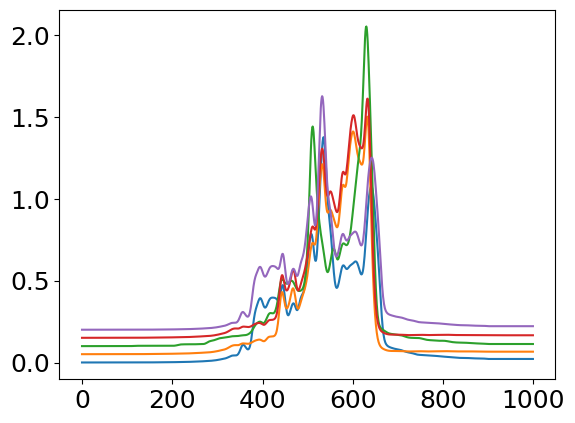

In [ ]:
cover = np.zeros((datatest.shape[0] + 200, datatest.shape[1]))
cover[100:-100, :] = datatest
cover[:100, :] = datatest[0, :]
cover[-100:, :] = datatest[-1, :]

for i in range(cover.shape[1]):
    plt.plot(range(cover.shape[0]), cover[:, i] + 0.05 * i)
plt.show()

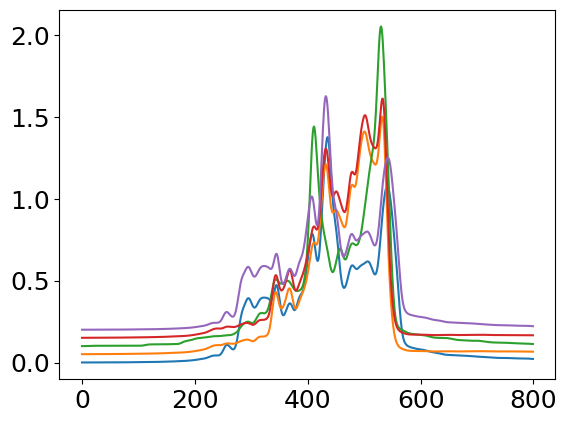

In [ ]:
cover_i = cover[100:900, :]
for i in range(cover_i.shape[1]):
    plt.plot(range(cover_i.shape[0]), cover_i[:, i] + 0.05 * i)
plt.show()

In [ ]:
datatest.shape[0]

800

In [ ]:
import copy

data_height = []

for i in range(21):
    data0 = copy.deepcopy(data[jjj])
    data_i = cover[60 + 4 * i : 60 + 4 * i + datatest.shape[0], :]
    data_i0 = data_i.reshape((1, -1))
    data0.x[:6] = data_i0

    data0.y = -(i - 10) * 0.1
    data_height.append(data0)
data_height[10].x[0].reshape(-1, 5)

array([[0.00036522, 0.00097945, 0.00021249, 0.00098348, 0.00037215],
       [0.00037099, 0.00099006, 0.00021943, 0.00099408, 0.00037796],
       [0.00037687, 0.00100091, 0.00023056, 0.00100483, 0.00038385],
       ...,
       [0.02232202, 0.0164198 , 0.0135064 , 0.01661624, 0.02247795],
       [0.02206211, 0.01635605, 0.01331674, 0.01654562, 0.02220212],
       [0.02181979, 0.01629501, 0.01313678, 0.01647588, 0.021933  ]])

In [ ]:
data_height = np.array(data_height)

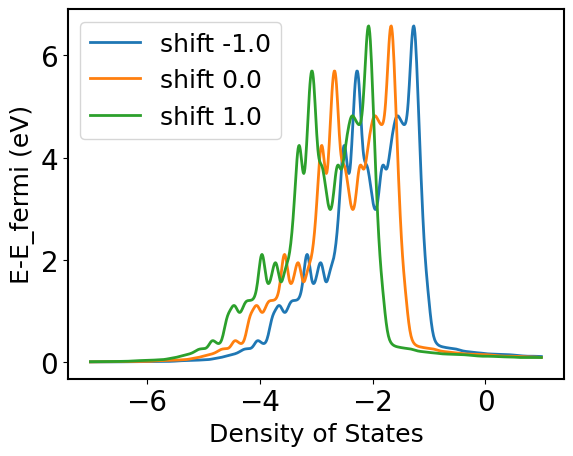

In [ ]:
fig, ax = plt.subplots()
for j in [0, 10, 20]:
    p = data_height[j].x[0].reshape(-1, 5)
    ax.plot(
        -7 + 0.010 * np.array(range(p.shape[0])),
        np.sum(p, axis=1),
        label=f"shift {(j-10)*0.1}",
        linewidth=2.0,
    )
ax.set_ylabel("E-E_fermi (eV)")
ax.set_xlabel("Density of States")
ax.legend()

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

plt.show()

In [ ]:
loader_h = DisjointLoader(MyGraphDataset(data_height), batch_size=1, epochs=1)

In [ ]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_h:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


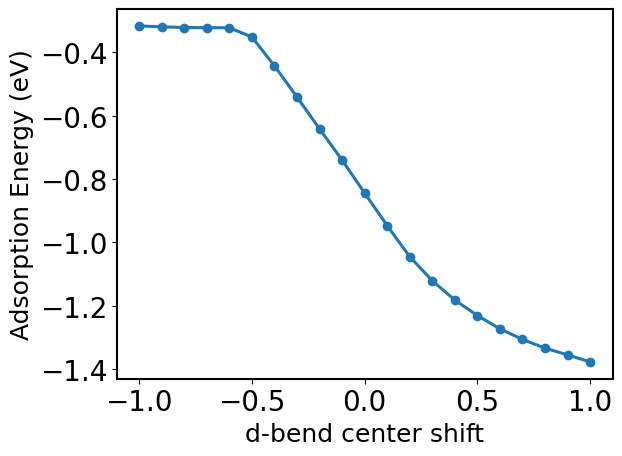

In [ ]:
plt.plot(targets, predictions, marker="o", linestyle="-", linewidth =2.2)

plt.xlabel("d-bend center shift")
plt.ylabel("Adsorption Energy (eV)")
plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

In [ ]:
datatest.shape

(800, 5)

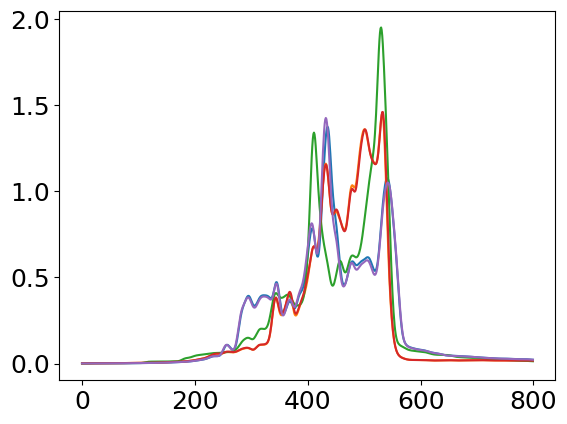

In [ ]:
for i in range(datatest.shape[1]):
    plt.plot(range(datatest.shape[0]), datatest[:, i])
plt.show()

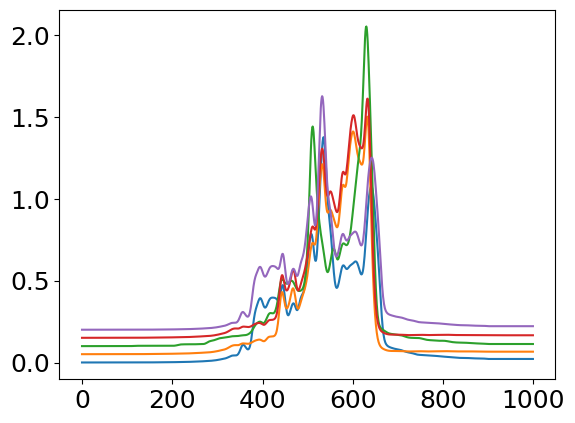

In [ ]:
cover = np.zeros((datatest.shape[0] + 200, datatest.shape[1]))
cover[100:-100, :] = datatest
cover[:100, :] = datatest[0, :]
cover[-100:, :] = datatest[-1, :]

for i in range(cover.shape[1]):
    plt.plot(range(cover.shape[0]), cover[:, i] + 0.05 * i)
plt.show()

In [ ]:
def interpolate(data, length):
    old_length = data.shape[0]
    x_old = np.linspace(0, 1, old_length)
    x_new = np.linspace(0, 1, length)
    y_new = np.interp(x_new, x_old, data)
    y_new = y_new * old_length / length
    return y_new

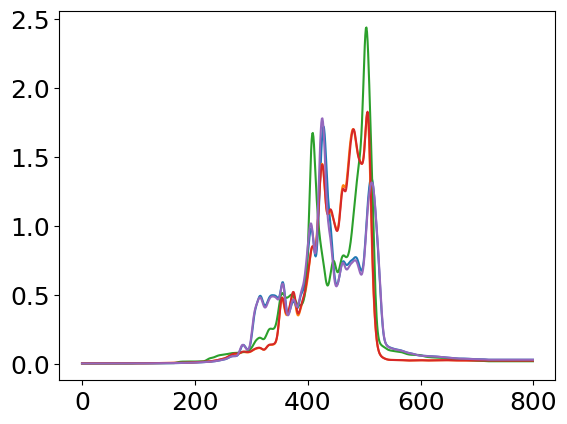

In [ ]:
for i in range(cover.shape[1]):
    plt.plot(range(800), interpolate(cover[:, i], 800))
plt.show()

In [ ]:
data_i = np.array([interpolate(cover[:, col], 800) for col in range(cover.shape[1])]).T

In [ ]:
a = np.array([1, 2, 3, 4])
np.tile(a, 1)[1:-1]

array([2, 3])

In [ ]:
data_width = []
for i in range(21):
    data0 = copy.deepcopy(data[jjj])
    data_i = cover[10 * i : cover.shape[0] - 10 * i, :]

    data_i = np.array(
        [interpolate(data_i[:, col], 800) for col in range(data_i.shape[1])]
    ).T

    pce = calculate_d_band_center(np.array(range(data_i.shape[0])), data_i)
    move = round(pce - 456)
    left = -min(move, 0)
    right = max(move, 0)
    up = np.tile(data_i[1, :], (left, 1))
    down = np.tile(data_i[-1, :], (right, 1))
    print(up.shape, data_i.shape, down.shape)
    data_i = np.concatenate((up, data_i, down), axis=0)
    data_i = data_i[right : data_i.shape[0] - left, :]
    data_i0 = data_i.reshape((1, -1))
    data0.x[:6] = data_i0
    data0.y = cover[10 * i : cover.shape[0] - 10 * i, :].shape[0] / 800
    data_width.append(data0)
data_width = np.array(data_width)

(9, 5) (800, 5) (0, 5)
(9, 5) (800, 5) (0, 5)
(8, 5) (800, 5) (0, 5)
(7, 5) (800, 5) (0, 5)
(6, 5) (800, 5) (0, 5)
(6, 5) (800, 5) (0, 5)
(5, 5) (800, 5) (0, 5)
(4, 5) (800, 5) (0, 5)
(3, 5) (800, 5) (0, 5)
(2, 5) (800, 5) (0, 5)
(1, 5) (800, 5) (0, 5)
(0, 5) (800, 5) (0, 5)
(0, 5) (800, 5) (1, 5)
(0, 5) (800, 5) (2, 5)
(0, 5) (800, 5) (4, 5)
(0, 5) (800, 5) (5, 5)
(0, 5) (800, 5) (6, 5)
(0, 5) (800, 5) (8, 5)
(0, 5) (800, 5) (10, 5)
(0, 5) (800, 5) (11, 5)
(0, 5) (800, 5) (13, 5)


-0.6575825466290439
-0.08483484807385366
0.7161492348759566


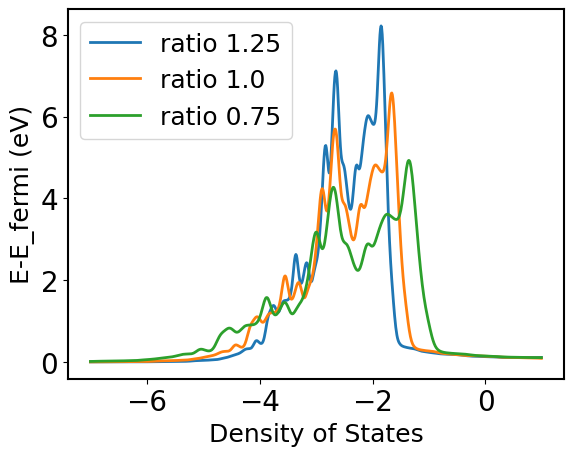

In [ ]:
fig, ax = plt.subplots()
for j in [0, 10, 20]:
    p = data_width[j].x[0].reshape(-1, 5)
    pce = calculate_d_band_center(np.array(range(p.shape[0])), p)
    print((pce - 456))
    ax.plot(
        -7 + 0.010 * np.array(range(p.shape[0])),
        np.sum(p, axis=1),
        label=f"ratio {((1000-20*j)/800)}",
        linewidth=2.0,
    )
ax.set_ylabel("E-E_fermi (eV)")
ax.set_xlabel("Density of States")
ax.legend()

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

plt.show()

In [ ]:
loader_w = DisjointLoader(MyGraphDataset(data_width), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_w:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

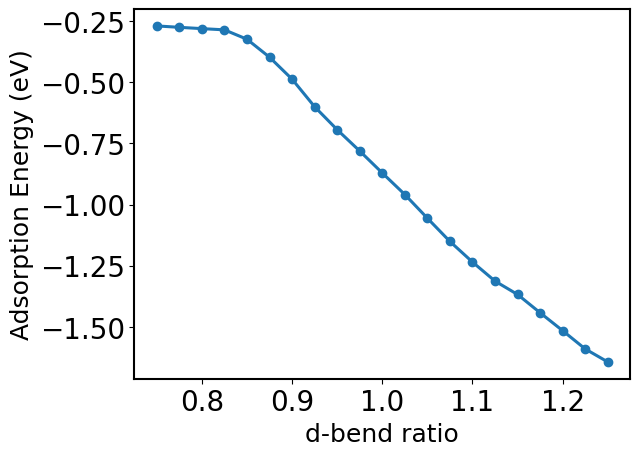

In [ ]:
plt.plot(targets, predictions, marker="o", linestyle="-", linewidth =2.2)

plt.xlabel("d-bend ratio")
plt.ylabel("Adsorption Energy (eV)")

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

In [ ]:
loader_data = DisjointLoader(MyGraphDataset(data_height), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

In [ ]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
fone.shape

(21, 1024)

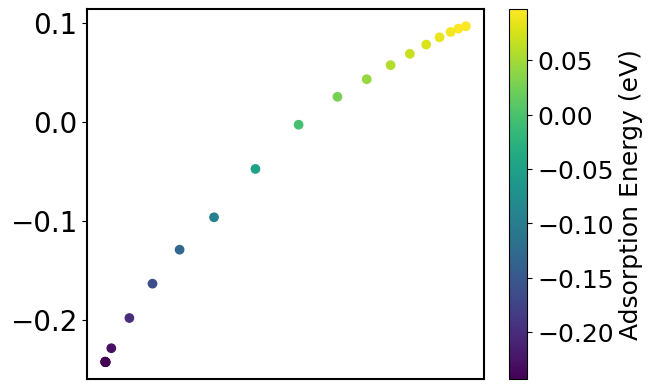

In [ ]:
pca3 = PCA(n_components=1)
X_embedded = pca3.fit_transform(fone)
plot_feature(X_embedded, predictions)